In [1]:
import chromadb
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
import numpy as np
import pandas as pd
import time
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt



c:\Users\trung\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


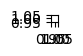

In [2]:
plt.gcf().set_size_inches(0.1, 0.1)
plt.plot(1,1)

In [3]:
client = chromadb.PersistentClient(path="chromadb")
apparel_collection = client.get_or_create_collection("apparel_50k", embedding_function=OpenCLIPEmbeddingFunction(), data_loader=ImageLoader())
apparel_collection.count()

90000

In [4]:
df = pd.read_csv("apparel_test.csv")

In [5]:
def query(collection, query_texts = None, query_images = None, n_results=5):
    prices =[]
    descriptions = []
    image_path = []

    response = None
    if query_texts is not None:
        response = collection.query(
            query_texts=query_texts,
            include=["metadatas", "documents", "uris"],
            n_results=n_results
        )
    elif query_images is not None:
        response = collection.query(
            query_images=query_images,
            include=["metadatas","documents", "uris"],
            n_results=n_results
        )

    if response is not None:
        # Extracting prices
        for metadata_lst in response["metadatas"]:
            prices.append([item["price"] for item in metadata_lst])

        # Extracting descriptions
        for i in range(len(response["documents"])):
            description_lst = []
            for j in range(len(response["documents"][i])):
                if response["documents"][i][j] is not None:
                    description_lst.append(response["documents"][i][j])
                else:
                    description_lst.append(response["metadatas"][i][j]["title"])
            descriptions.append(description_lst)

        # Extracting image paths
        for i in range(len(response["uris"])):
            image_path_lst = []
            for j in range(len(response["uris"][i])):
                if response["uris"][i][j] is not None:
                    image_path_lst.append(response["uris"][i][j])
                else:
                    image_path_lst.append(response["metadatas"][i][j]["image_path"])
            image_path.append(image_path_lst)


    return prices, descriptions, image_path

def display_images(image_paths, descriptions=None):     # Display images side by side
    fig, ax = plt.subplots(1, len(image_paths), figsize=(20, 20))
    for i in range(len(image_paths)):
        img = Image.open(image_paths[i])
        ax[i].imshow(img)
        ax[i].axis('off')
        if descriptions is not None:
            ax[i].set_title(descriptions[i], fontsize=10, wrap=True)

def query_and_display(collection, query_texts = None, query_images = None, n_results=5):
    prices, descriptions, image_paths = query(collection, query_texts, query_images, n_results)
    for i in range(len(image_paths)):
        display_images(image_paths[i], descriptions[i])
    return prices, descriptions, image_paths

def plot_percentage_error(predicted_prices, test_prices, plot_name='Percentage Error for each product'):
    # predited_prices: list of lists, where each list contains the predicted prices for a product. e.g. [[10, 30], [60, 100], [90, 110]]
    # test_prices: list of test prices for each product. e.g. [20, 50, 100]
    
    num_products = len(test_prices)  

    percentage_errors_lst = []
    # Iterate through each product
    for i in range(num_products):
        percentage_errors = [(predicted_price - test_prices[i]) / test_prices[i] * 100 for predicted_price in predicted_prices[i]]
        percentage_errors_lst += percentage_errors
        # Use the product index as the x-value for all predictions of this product
        x_values = [i for _ in predicted_prices[i]]

        # Plot percentage errors for this product
        plt.scatter(x_values, percentage_errors, color='red')  # Plotting errors in blue

    plt.ylim(-200, 200)
    plt.xlabel('Product Index')
    plt.ylabel('Percentage Error (%)')
    plt.title(plot_name)
    plt.axhline(0, color='grey')  
    plt.axhline(25, color='green', linestyle='--')
    plt.axhline(-25, color='green', linestyle='--')

    mape = np.mean(np.abs(percentage_errors_lst))
    plt.text(0, -250, "Mean Absolute Percentage Error: {:.2f}%".format(mape), fontsize=12)
    plt.text(0, -300, "Note: ylim is set to (-200, 200) but some errors may be outside this range", fontsize=12)

    plt.gcf().set_size_inches(20, 7)
    
    # plt.savefig('rag_eval/' + plot_name + '.png')

    plt.show()

In [39]:
#7412
size = 100
random_state = 7412
test_prices = df["price"].sample(n=size, random_state=random_state).values
test_descriptions = df["title"].sample(n=size, random_state=random_state).values
test_image_paths = df["imgName"].sample(n=size, random_state=random_state).values

# print(test_descriptions)
# print(test_prices)
# Query using text
retrieved_prices, retrieved_descriptions, retrieved_image_paths = query(apparel_collection, query_texts=test_descriptions, n_results=10)

print(retrieved_descriptions)
print(retrieved_prices)

[['Teacher Shirts Funny Women’s Teacher Life T Shirt Graphic Tees Casual Soft Cotton Shirts Tops', 'Officially Licensed Short Sleeve Crew Neck T-Shirt for Men Women Unisex Tee', "Trophy Husband | Funny Dad Joke Groom Humor Marriage Anniversary Hubby Saying Cute Dude Men's T-Shirt", 'I Fix Stuff and I Know Things Hat for Men I Fix Stuff Hat Cool Stuff Hat for Men Funny', 'Hot Dogs Lover Hat It’s A Bad Day to Be A Glizzy Hat for Women Dad Hats Trendy Cap', 'Christian Oversized Tshirts Woman Jesus Faith Tshirt Bible Verse Shirts Casual Christians Inspirational Tee Tops', 'Gifts for Men Worlds Best Ever Hat Birthday Gifts Baseball Cap Funny Dad Hat', 'Security T-Shirt Front Back Print Mens Tee Staff Event Uniform Bouncer Screen Printed', 'But Did You Die Muscle Tank Top Women Workout Tank Vacation Shirt Casual Letters Print Sleeveless Holiday Shirt', 'Cute Graphic Tees for Women Graphic T Shirts, Casual Bella Canvas Shirts for Women, Colorful Vintage Tee Shirt'], ['Women Punk Style Shoulde

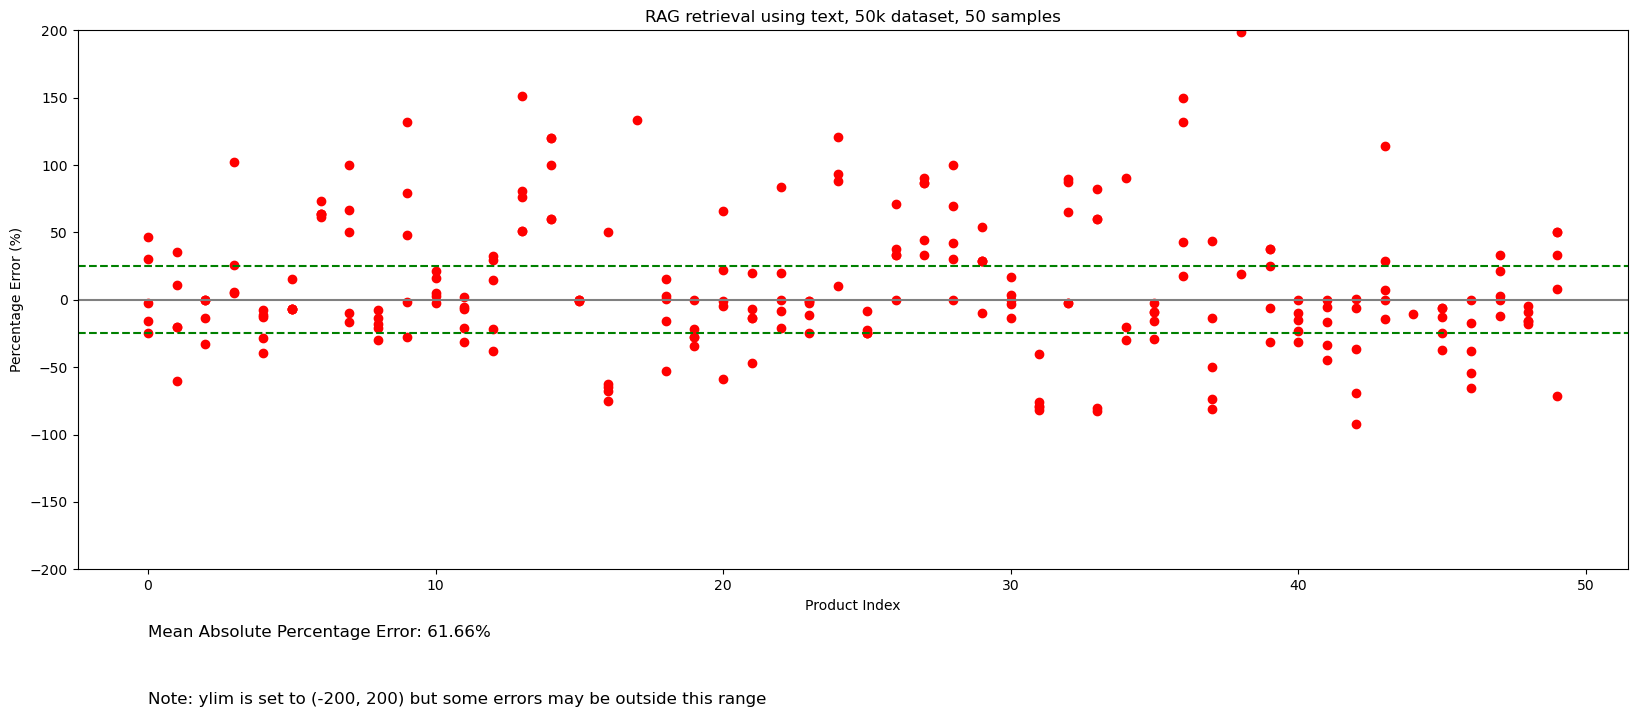

In [27]:
# price_range = [[min(retrieved_price), max(retrieved_price)] for retrieved_price in retrieved_prices]
plot_percentage_error(retrieved_prices, test_prices, plot_name='RAG retrieval using text, 50k dataset, {} samples'.format(size))

In [17]:
import requests
import os

mixtral = True
if mixtral:
    API_URL = "https://api-inference.huggingface.co/models/mistralai/Mixtral-8x7B-Instruct-v0.1"
    print("Using Mixtral model")
else:
    API_URL = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2"
    print("Using Mistral model")

print("API_URL:", API_URL)
headers = {"Authorization": f"Bearer {os.environ['HF_API_TOKEN']}"}
def request_hf(payload):
    try:
        response = requests.post(API_URL, headers=headers, json={"inputs": payload, "parameters": {"max_new_tokens": 500}, "options": {"use_cache": False}})
        return response.json()[0]['generated_text']
    except Exception as e:
        print(response.text)
        return "Error"

Using Mixtral model
API_URL: https://api-inference.huggingface.co/models/mistralai/Mixtral-8x7B-Instruct-v0.1


In [19]:
prompt_template1 = """<s> [INST]\
    Answer if the two products are in the same type of apparel category.\
    If they are the same type of apparel (e.g. both are T-shirts, both are shoes), they are in the same category.
    Product 1: {}
    Product 2: {}  

    The result has to be boolean value put inside angle brackets (either <True> or <False>). Only use angle brackets in the final results [/INST] </s>
    """
prompt_template2 = """<s> [INST]\
    Imagine you are a apparel retailer and you want to know if the two products are in the same type of apparel category.\
    There are a few criteria that need to satisfied in order for two products to be in the same category.\
    - Same type of products (e.g. both are T-shirts, both are shoes)
    - Same functionality: Consider the primary use of the product (e.g. running shoes, casual shoes)
    - Same target users: Consider gender, age group, etc.
    These are just a few examples of the criteria. You can use your own judgement to decide if the two products are in the same category.
    These are the two products' descriptions:
    Product 1: {}
    Product 2: {}  

    The result has to be boolean value put inside angle brackets (either <True> or <False>). Only use angle brackets in the final results [/INST] </s>
    """
prompt_template3 = """<s> [INST]\
    Imagine you are a apparel retailer and you want to know if the two products are in the same type of apparel category.\
    There are a few criteria that need to satisfied in order for two products to be in the same category.\
    - Same type of products (e.g. both are T-shirts, both are watches)
    - Same functionality: Consider the primary use of the product (e.g. running shoes, casual shoes)
    - Same target users: Consider gender, age group, etc.
    - Similar style: Consider the design, color, etc.
    - Same material: Consider the material used in the product
    - Same brand: Consider the brand name
    You should evaluate each of these criteria and decide if the two products are in the same category.
    Some of these criteria may not be available in the product description. In that case, you can make your own judgement based on the available information.\
    These are just a few examples of the criteria. You can use your own judgement to decide if the two products are in the same category.
    These are the two products' descriptions:
    Product 1: {}
    Product 2: {}  

    The result has to be boolean value put inside angle brackets (either <True> or <False>). Only use angle brackets in the final results [/INST] </s>
    """

In [40]:
prompt_template = prompt_template3
filter_mask = []
for i in range(len(retrieved_descriptions[0])):
    print(f"{test_descriptions[0]} vs {retrieved_descriptions[0][i]}")
    prompt = prompt_template.format(test_descriptions[0], retrieved_descriptions[0][i])
    response = request_hf(prompt).split("[/INST] </s>")[-1]
    print(response)
    if '<true>' in response.lower():
        filter_mask.append(True)
    else:
        filter_mask.append(False)
print(filter_mask)


Don't Bully Me I'll Cum Funny Offensive Shirt Humorous Saying Tee Sarcastic T-Shirt vs Teacher Shirts Funny Women’s Teacher Life T Shirt Graphic Tees Casual Soft Cotton Shirts Tops

    
Based on the given product descriptions, we can evaluate the criteria as follows:

* Same type of products: Both are T-shirts.
* Same functionality: Both are casual shirts.
* Same target users: Product 1 does not specify a target user, but Product 2 is targeted towards women teachers.
* Similar style: Product 1 has a humorous and sarcastic saying, while Product 2 has a graphic design related to teaching.
* Same material: Both products do not specify the material used.
* Same brand: Both products do not specify the brand name.

Based on the above evaluation, the two products are not in the same category as they have different target users and styles. Therefore, the answer is:

<False>
Don't Bully Me I'll Cum Funny Offensive Shirt Humorous Saying Tee Sarcastic T-Shirt vs Officially Licensed Short Sleeve 

In [42]:
filtered_descriptions = [retrieved_descriptions[0][i] for i in range(len(retrieved_descriptions[0])) if filter_mask[i]]
for i in range(len(filtered_descriptions)):
    print(filtered_descriptions[i])

filtered_prices = [retrieved_prices[0][i] for i in range(len(retrieved_prices[0])) if filter_mask[i]]
print(filtered_prices)

print("Original prices:", test_prices[0])
print("Price range:", min(filtered_prices), max(filtered_prices))

Trophy Husband | Funny Dad Joke Groom Humor Marriage Anniversary Hubby Saying Cute Dude Men's T-Shirt
[21.95]
Original prices: 18.99
Price range: 21.95 21.95


In [22]:
llm_responses = {}
all_false = 0
num_true = 0
num_false = 0
false_products = []

filtered_prices = []
for i in range(len(retrieved_descriptions)):
    filtered_price_lst = []
    for j in range(len(retrieved_descriptions[i])):
        print(f"{i}-{j}. {test_descriptions[i]} vs {retrieved_descriptions[i][j]}")
        prompt = prompt_template.format(test_descriptions[i], retrieved_descriptions[i][j])
        llm_response = request_hf(prompt).split("[/INST] </s>")[-1]
        if llm_response == "Error":
            print(f"Rate limit exceeded. Sleeping for 1 hours since {time.ctime()}")
            time.sleep(3660)
            llm_response = request_hf(prompt).split("[/INST] </s>")[-1]
            
        llm_responses[f"{i}-{j}"] = llm_response


        # print(llm_response)

        if '<true>' in llm_response.lower():
            filtered_price_lst.append(retrieved_prices[i][j])
            num_true += 1
            print("True")
        else:
            num_false += 1
            print("False")
            false_products.append(f"{i}-{j}. {test_descriptions[i]} vs {retrieved_descriptions[i][j]}")
        
        if len(filtered_price_lst) == 5:
            break

    if len(filtered_price_lst) == 0:
        all_false += 1
        filtered_price_lst = retrieved_prices[i][:5]
    else:
        filtered_prices.append(filtered_price_lst)

0-0. Men's Sneaker vs Men's Sneaker
True
0-1. Men's Sneaker vs Men's Sneaker
True
0-2. Men's Sneaker vs Men's Sneaker
True
0-3. Men's Sneaker vs Men's Sneaker
True
0-4. Men's Sneaker vs Men's Sneaker
True
1-0. Women's Sheer Spider Web Arm Warmer vs Women's Arm Warmers Long Fingerless Gloves
True
1-1. Women's Sheer Spider Web Arm Warmer vs Women's Distressed Glove Arm Warmers Costume Accessory, O/S, Black
True
1-2. Women's Sheer Spider Web Arm Warmer vs fingerless fishnet gloves for women kids girls fish net arm sleeve 80s
True
1-3. Women's Sheer Spider Web Arm Warmer vs Womens Fingerless Gloves Elbow Lace Up steampunk Costume Arm Warmer
True
1-4. Women's Sheer Spider Web Arm Warmer vs Punk Gothic Rock Long Arm Warmer Fingerless Gloves
False
1-5. Women's Sheer Spider Web Arm Warmer vs Women's Lace Keyhole Fingerless Gloves
True
2-0. Men's Charged Assert 10 Running Shoe, (102) Mod Gray/Mod Gray/White vs Men's Charged Assert 10 Running Shoe, (102) Mod Gray/Mod Gray/White, 13
True
2-1. Men

KeyboardInterrupt: 

In [31]:
print(llm_responses["5-4"])


    
Based on the given product descriptions, we can evaluate the criteria as follows:

* Same type of products: Both products are shoes, so they are the same type of product.
* Same functionality: Product 1 is a pump-style shoe, while Product 2 is a dance shoe. They have different functionalities.
* Same target users: Both products are for women, so they have the same target users.
* Similar style: Product 1 has a vintage and pinup style, while Product 2 has a more functional and practical style. They are not similar in style.
* Same material: The product descriptions do not provide information about the materials used in the products, so we cannot make a judgement based on this criterion.
* Same brand: The product descriptions do not provide information about the brands of the products, so we cannot make a judgement based on this criterion.

Based on the above evaluation, we can conclude that the two products are not in the same category, as they have different functionalities and s

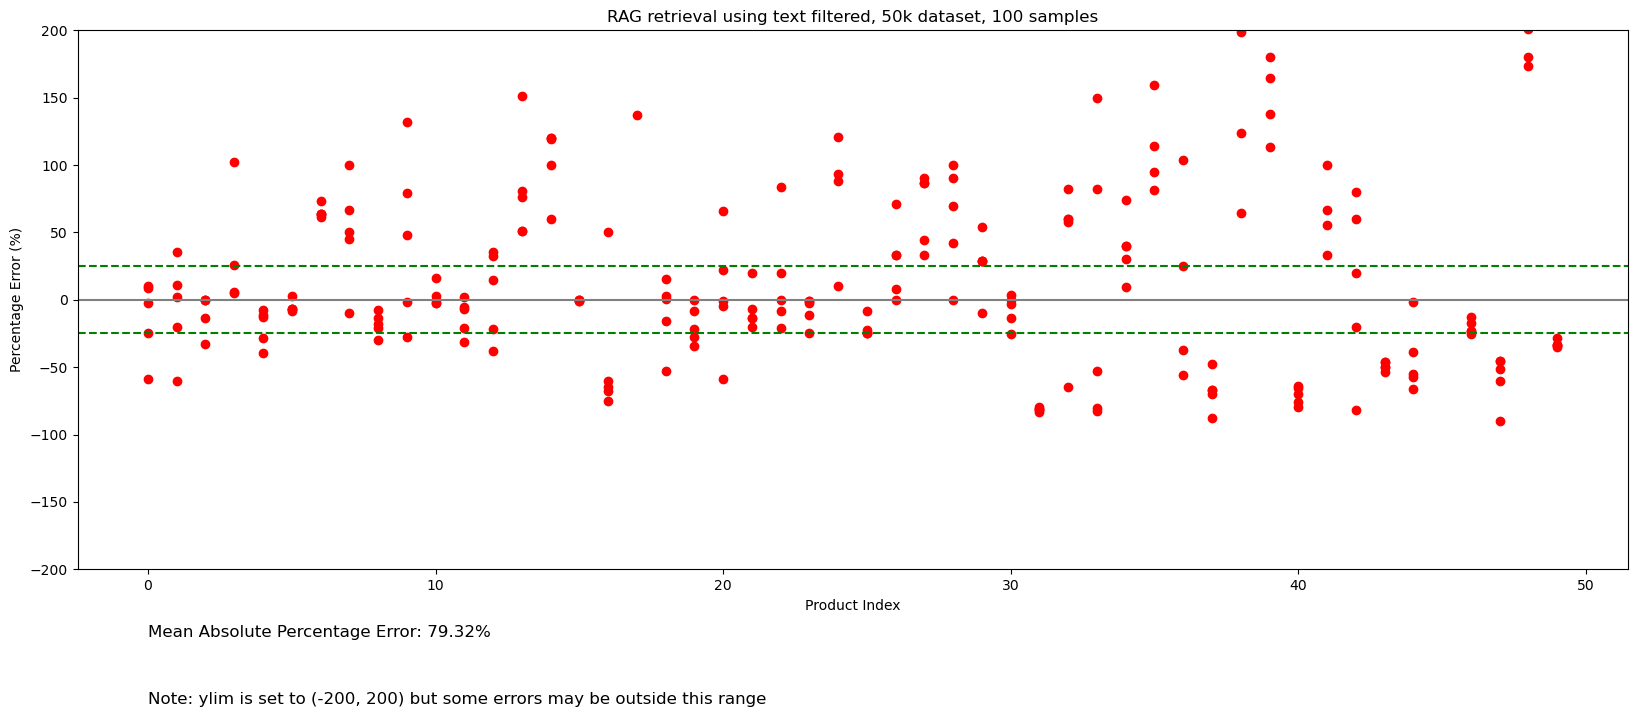

No products found: 2
True: 286
False: 122
1-4. Women's Sheer Spider Web Arm Warmer vs Punk Gothic Rock Long Arm Warmer Fingerless Gloves
5-0. Women's Two Tones Wing Tips Retro Rockability 1950s Vintage T-Strap Pinup Style Pump Flapper Kimmy-66 by Chase + Chloe vs New Kimmy-36 Women's Teardrop Cut Out T-Strap Mid Heel Dress Pumps
5-4. Women's Two Tones Wing Tips Retro Rockability 1950s Vintage T-Strap Pinup Style Pump Flapper Kimmy-66 by Chase + Chloe vs Women's Jr. Footlight T-Strap Dance Shoe
5-5. Women's Two Tones Wing Tips Retro Rockability 1950s Vintage T-Strap Pinup Style Pump Flapper Kimmy-66 by Chase + Chloe vs Women's T-Strap Character Shoes Latin Ballroom Dance Heels Black Wedding Pumps
5-6. Women's Two Tones Wing Tips Retro Rockability 1950s Vintage T-Strap Pinup Style Pump Flapper Kimmy-66 by Chase + Chloe vs Flats Dance Shoes Women Low Heel Genuine Leather Pumps T-Strap Latin Ballroom Salsa Shoes,1"
5-7. Women's Two Tones Wing Tips Retro Rockability 1950s Vintage T-Strap Pi

In [23]:
plot_percentage_error(filtered_prices[:50], test_prices[:50], plot_name='RAG retrieval using text filtered, 50k dataset, {} samples'.format(size))
print("No products found:", all_false)
print("True:", num_true)
print("False:", num_false)
for product in false_products:
    print(product)